In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
alpha = 2.5         # sensitivity factor to occupancy (tune as needed)
base_price = 10.0

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("dataset.csv")

Saving dataset.csv to dataset.csv


In [ ]:
df['price'] = base_price

In [ ]:
new_prices = []

In [ ]:
for lot_id, group in df.groupby('ID'):
    price = base_price
    prices = []
    for _, row in group.iterrows():
        occ = row['Occupancy']
        cap = row['Capacity']
        utilization = occ / cap if cap > 0 else 0
        price = price + alpha * utilization
        price = max(5, min(30, price))  # bound the price between $5 and $30
        prices.append(price)
    new_prices.extend(prices)


In [ ]:
df['Model1_Price'] = new_prices

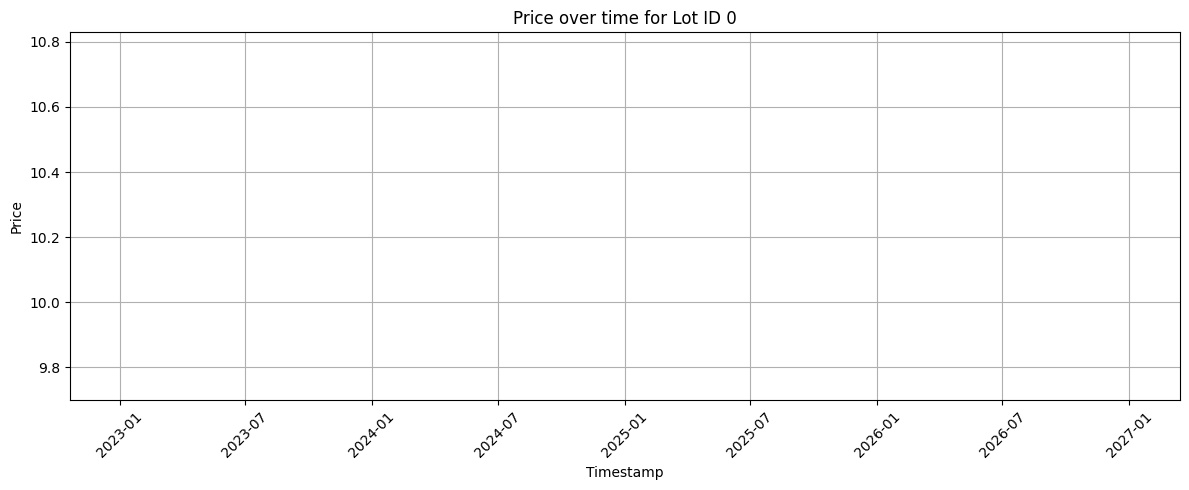

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sample_lot = df[df['ID'] == df['ID'].unique()[0]]
sns.lineplot(x=sample_lot['timestamp'], y=sample_lot['Model1_Price'])
plt.title(f"Price over time for Lot ID {sample_lot['ID'].iloc[0]}")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Convert relevant columns to numeric (if not already)
cols_to_convert = ['Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert 'VehicleType' to numerical weights (if needed)
vehicle_type_map = {'car': 1.0, 'bike': 0.7, 'truck': 1.3}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_map).fillna(1.0)


In [21]:
df = df.sort_values(by=['ID', 'timestamp'])

In [22]:
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_weights)

In [23]:
df['VehicleTypeWeight'] = df['VehicleTypeWeight'].fillna(1.0)

In [24]:
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['TrafficNormalized'] = df['TrafficConditionNearby'] / df['TrafficConditionNearby'].max()
df['QueueNormalized'] = df['QueueLength'] / df['QueueLength'].max()

In [25]:
alpha = 1.5
beta = 0.8
gamma = 0.5
delta = 0.9
epsilon = 1.2
lambda_factor = 0.6
base_price = 10

In [26]:
df['RawDemand'] = (
    alpha * df['OccupancyRate'] +
    beta * df['QueueNormalized'] -
    gamma * df['TrafficNormalized'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['VehicleTypeWeight']
)

In [27]:
df['NormalizedDemand'] = (df['RawDemand'] - df['RawDemand'].min()) / (df['RawDemand'].max() - df['RawDemand'].min())

In [28]:
df['Model2_Price'] = base_price * (1 + lambda_factor * df['NormalizedDemand'])
df['Model2_Price'] = df['Model2_Price'].clip(lower=5, upper=20)

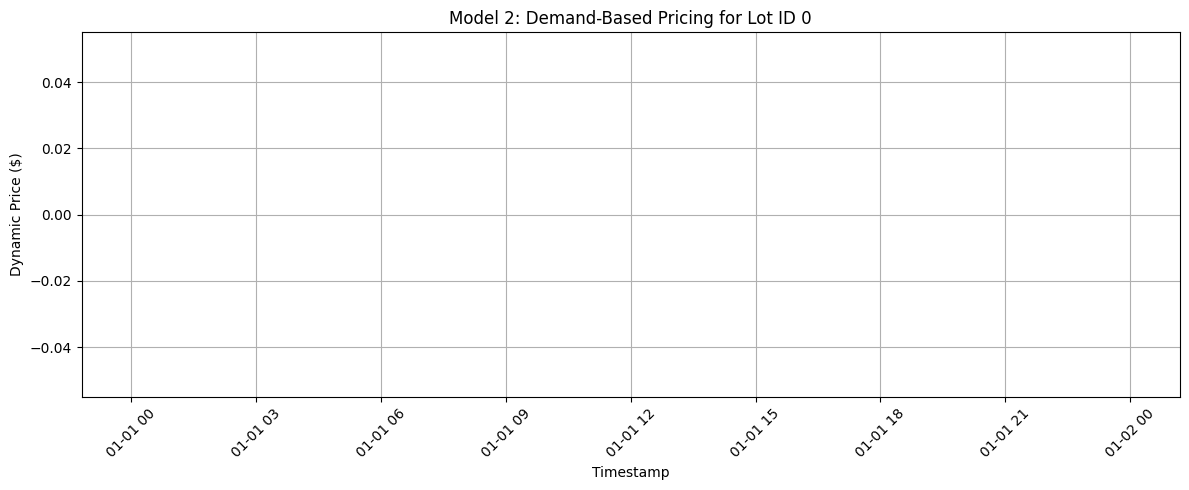

In [29]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sample_lot = df[df['ID'] == df['ID'].unique()[0]]
sns.lineplot(x=sample_lot['timestamp'], y=sample_lot['Model2_Price'])
plt.title(f"Model 2: Demand-Based Pricing for Lot ID {sample_lot['ID'].iloc[0]}")
plt.xlabel("Timestamp")
plt.ylabel("Dynamic Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
import numpy as np

In [31]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [32]:
parking_lots = df['ID'].unique()
base_price = 10
lambda_val = 0.25

In [33]:
df['comp_price'] = base_price

for t in df['timestamp'].sort_values().unique():
    current_data = df[df['timestamp'] == t].copy()

    updated_prices = []

    for idx, row in current_data.iterrows():
        lot_id = row['ID']
        lat1, lon1 = row['Latitude'], row['Longitude']
        occupancy = float(row['Occupancy'])
        capacity = float(row['Capacity'])
        queue = float(row['QueueLength'])
        traffic = float(row['TrafficConditionNearby'])
        special = int(row['IsSpecialDay'])

        try:
            vtype_weight = {'car': 1, 'bike': 0.7, 'truck': 1.3}[row['VehicleType'].lower()]
        except:
            vtype_weight = 1.0

        demand = (occupancy / capacity) + 0.2*queue - 0.1*traffic + 0.1*special + 0.3*vtype_weight
        demand = np.clip(demand, 0, 2)
        raw_price = base_price * (1 + lambda_val * demand)

        # Check for competitors nearby
        nearby_prices = []

        for jdx, other in current_data.iterrows():
            if row['ID'] == other['ID']:
                continue  # skip self

            lat2, lon2 = other['Latitude'], other['Longitude']
            dist = haversine(lat1, lon1, lat2, lon2)

            if dist <= 0.5:  # Within 0.5 km
                other_occ = float(other['Occupancy'])
                other_cap = float(other['Capacity'])
                if other_occ < other_cap * 0.85:  # Available capacity
                    nearby_prices.append(other['comp_price'])

        if len(nearby_prices) > 0:
            avg_nearby = np.mean(nearby_prices)
            if (occupancy / capacity) > 0.9 and avg_nearby < raw_price:
                # High demand, but nearby cheaper → reroute or lower
                raw_price = max(avg_nearby - 0.5, base_price * 0.5)
            elif avg_nearby > raw_price:
                # Nearby costlier → increase price slightly
                raw_price = min(avg_nearby + 0.5, base_price * 2)

        updated_prices.append(raw_price)

    # Update all rows at this timestamp
    df.loc[df['timestamp'] == t, 'comp_price'] = updated_prices

/tmp/ipython-input-33-3532878106.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[np.float64(nan)]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['timestamp'] == t, 'comp_price'] = updated_prices


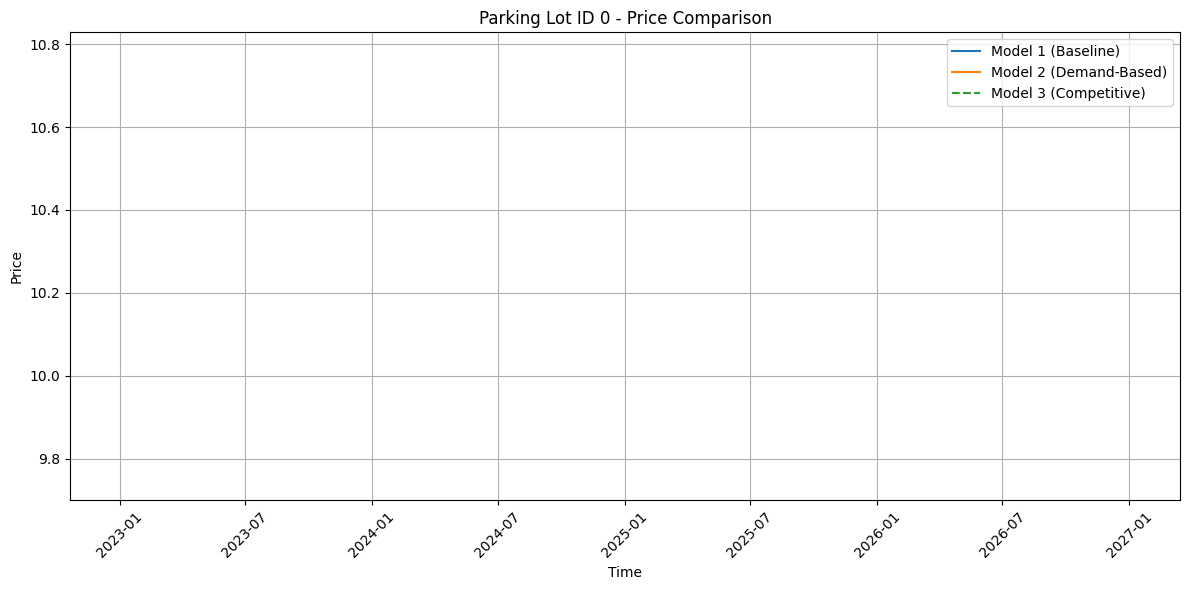

In [36]:
import matplotlib.pyplot as plt

lot_id = df['ID'].unique()[0]  # or any specific parking lot ID
lot_data = df[df['ID'] == lot_id]

plt.figure(figsize=(12, 6))
plt.plot(lot_data['timestamp'], lot_data['Model1_Price'], label='Model 1 (Baseline)')
plt.plot(lot_data['timestamp'], lot_data['Model2_Price'], label='Model 2 (Demand-Based)')
plt.plot(lot_data['timestamp'], lot_data['comp_price'], label='Model 3 (Competitive)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Parking Lot ID {lot_id} - Price Comparison')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
df.columns

Index(['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude',
       'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength',
       'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime', 'price',
       'timestamp', 'Model1_Price', 'VehicleTypeWeight', 'OccupancyRate',
       'TrafficNormalized', 'QueueNormalized', 'RawDemand', 'NormalizedDemand',
       'Model2_Price', 'comp_price'],
      dtype='object')